In [58]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

This cell loads the quarterly predictive signals dataset, converts the raw date into year/quarter fields, and documents each variable (price, size, liquidity, value, momentum, profitability, investment, beta, and volatility). These signals will later be used for investability screens, risk controls, and building the value and beta-tilted portfolios.








In [59]:
# Read predictive signals updated at calendar quarter-end, as well as variables for liquidity screens
signals = pd.read_csv(r"C:\Users\Jonbf5\OneDrive - University of Cincinnati\Classes\FIN7032 Quant Equity Investing\Data Sessions\Data Storage\signals_quarterly.csv")

# Format date variable
signals['date'] = pd.to_datetime(signals['date'], format='%Y%m%d')
signals['year'] = signals['date'].dt.year
signals['quarter'] = signals['date'].dt.quarter

# Variables
# permno ~ unique stock ID
# date ~ last trading day in a calendar quarter (consistent with date in msf)
# prc ~ share price (at quarter-end)
# MC ~ market capitalization at quarter-end ($Bil)
# DTV ~ average daily trading volume ($Mil) druing the past 6 months
# BM ~ book-to-market (updated using the latest quarterly accounting statements and quarter-end ME)
# R11 ~ momentum (past 12-to-2-month cumulative return)
# IA ~ investment-to-asssets (trailing 4-quarter asset growth using the latest quarterly accounting statements)
# ROE ~ return on equity (based on the most recent announced quarterly earnings report)
# beta ~ market beta (based on returns during the past 60 months)
# vol ~ daily return volatility (%, based on daily returns in the most recent month)
print(signals)

# For the signals, be clear about whether it "positively" or "negatively" predicts future returns
# positively: BM, R11, ROE
# negatively: IA
# Size/liquidity screens: MC, DTV
# Risk controls: beta, vol

        permno       date     prc          MC           DTV        BM  \
0        10001 1993-12-31   18.38    0.020053      0.009723  0.573449   
1        10001 1994-03-31   17.25    0.018820      0.008353  0.618234   
2        10001 1994-06-30    8.63    0.018908      0.005206  0.639242   
3        10001 1994-09-30    9.25    0.020452      0.004705  0.628455   
4        10001 1994-12-30    8.00    0.017792      0.002972  0.705317   
...        ...        ...     ...         ...           ...       ...   
581645   93436 2022-12-30  123.18  389.741520  19569.478909  0.093390   
581646   93436 2023-03-31  207.46  657.505882  24395.015188  0.060640   
581647   93436 2023-06-30  261.77  830.857980  29356.666587  0.053903   
581648   93436 2023-09-29  250.22  795.449380  29204.271367  0.060411   
581649   93436 2023-12-29  248.48  789.898290  29111.794688  0.064606   

             R11        IA       ROE      beta       vol  year  quarter  
0       0.253691  0.255446 -0.027836 -0.105077  2

This cell applies investability screens (price ≥ $5, MC > 0, BM/beta non-missing, DTV > 10M) and keeps the top 1500 stocks by market cap each quarter to form a large-cap liquid universe. It then builds a BM-based value score, flags the top 30% as the value universe each quarter, and reports how many stocks and value names remain after these filters.








In [60]:
# Start from your signals DataFrame
sig = signals.copy()

# ---- 1. Basic cleaning & investability screens ----
# Tweak these if needed to match class conventions
sig = sig[
    (sig['prc'] >= 5) &            # avoid penny stocks
    (sig['MC'] > 0) &              # positive market cap
    sig['BM'].notna() &            # need value signal
    sig['beta'].notna() &          # need beta
    (sig['DTV'] > 10)          # for liquidity if needed
].copy()

print("Obs after basic screens:", len(sig))

# ---- 2. Limit to a large-cap / liquid universe each quarter ----
# Example: keep top 1500 by MC per quarter
sig['mc_rank_q'] = sig.groupby('date')['MC'].rank(method='first', ascending=False)
sig = sig[sig['mc_rank_q'] <= 1500].copy()

print("Obs after top-1500 MC per quarter:", len(sig))

# ---- 3. Build a pure value score (you can extend later) ----
# For now use BM only; we can add E/P, C/P etc. later if available.

# Percentile rank of BM within each quarter (0–1, higher = more value)
sig['pBM'] = sig.groupby('date')['BM'].rank(method='first', pct=True)

# Simple value score = percentile BM (higher = more value)
sig['value_score'] = sig['pBM']

# ---- 4. Flag "value universe" (e.g., top 30% by value_score each quarter) ----
sig['value_rank_q'] = sig.groupby('date')['value_score'].rank(method='first')
sig['value_pct_q'] = sig.groupby('date')['value_rank_q'].transform(
    lambda r: r / r.max()
)

value_cutoff = 0.70  # top 30%
sig['is_value'] = (sig['value_pct_q'] >= value_cutoff).astype(int)

print("Number of quarter-ends:", sig['date'].nunique())
print("Avg stocks per quarter (post filters):", sig.groupby('date')['permno'].nunique().mean())
print("Avg value stocks per quarter:", sig[sig['is_value'] == 1].groupby('date')['permno'].nunique().mean())

sig.head()

Obs after basic screens: 121795
Obs after top-1500 MC per quarter: 121741
Number of quarter-ends: 121
Avg stocks per quarter (post filters): 1006.1239669421487
Avg value stocks per quarter: 302.3884297520661


,permno,date,prc,MC,DTV,BM,R11,IA,ROE,beta,vol,year,quarter,mc_rank_q,pBM,value_score,value_rank_q,value_pct_q,is_value
551,10026,2018-06-29,152.47,2.850732,10.470274,0.263737,0.082484,0.089205,0.023719,0.598236,0.844221,2018,2,919.0,0.407517,0.407517,553.0,0.407517,0
554,10026,2019-03-29,158.84,2.988575,10.984125,0.271505,0.147795,0.074704,0.021599,0.475503,0.955127,2019,1,848.0,0.407181,0.407181,533.0,0.407181,0
555,10026,2019-06-28,160.95,3.030689,11.632983,0.271076,0.065109,0.079729,0.024775,0.391267,1.033271,2019,2,867.0,0.421983,0.421983,549.0,0.421983,0
556,10026,2019-09-30,192.00,3.627840,14.415745,0.231004,0.291942,0.073419,0.036838,0.346104,1.093411,2019,3,765.0,0.340927,0.340927,434.0,0.340927,0
557,10026,2019-12-31,184.27,3.482703,16.862272,0.247703,0.290848,0.089100,0.030216,0.305219,0.833386,2019,4,822.0,0.395493,0.395493,509.0,0.395493,0


This cell builds the baseline value portfolio by keeping only value stocks, renaming the quarter-end date to `qdate`, and computing market-cap-weighted holdings within each quarter. It stores only the key fields (date, permno, weight, BM, beta) that will be used later for portfolio return and risk calculations.









In [61]:
# Start from the cleaned signal dataframe `sig` with is_value already defined
port_holdings = sig[sig['is_value'] == 1].copy()

# Rename quarter-end date for clarity
port_holdings = port_holdings.rename(columns={'date': 'qdate'})

# Compute value-weighted (MC-weighted) portfolio weights within each quarter
port_holdings['w_mc'] = port_holdings.groupby('qdate')['MC'].transform(
    lambda x: x / x.sum()
)

# Keep only what we need
port_holdings = port_holdings[['qdate', 'permno', 'w_mc', 'BM', 'beta']]

port_holdings.head()

,qdate,permno,w_mc,BM,beta
745,2007-03-30,10032,0.000203,0.606107,2.713896
763,2011-09-30,10032,0.000315,0.805005,1.460834
1242,2014-09-30,10051,0.000136,0.921706,0.950686
1441,1993-12-31,10078,0.004088,0.603490,1.598370
1443,1994-06-30,10078,0.002952,0.759159,1.313873


In [62]:
# === 2.1 Read monthly returns ===
# Adjust the path and column names to match your class data
msf = pd.read_csv(r"C:\Users\Jonbf5\OneDrive - University of Cincinnati\Classes\FIN7032 Quant Equity Investing\Data Sessions\Data Storage\msf_6123.csv")

msf['date'] = pd.to_datetime(msf['date'], format='%Y%m%d')
# Assume columns: permno, date, ret (decimal, e.g. 0.02 = 2%)

# Sort for merge_asof
msf = msf.sort_values('date')

# === 2.2 Attach the most recent quarter-end (qdate) to each month ===
qdates = port_holdings['qdate'].drop_duplicates().sort_values().to_frame('qdate')

msf = pd.merge_asof(
    msf,
    qdates,
    left_on='date',
    right_on='qdate',
    direction='backward'
)

# Drop months before first qdate (no portfolio yet)
msf = msf[msf['qdate'].notna()].copy()

# === 2.3 Merge in the portfolio weights ===
msf_port = msf.merge(
    port_holdings[['qdate', 'permno', 'w_mc']],
    on=['qdate', 'permno'],
    how='inner'   # only stocks in the portfolio
)

# === 2.4 Compute monthly portfolio return as weight * stock return ===
msf_port['contrib'] = msf_port['w_mc'] * msf_port['ret']

port_ret = msf_port.groupby('date')['contrib'].sum().to_frame('ret_port')
port_ret = port_ret.sort_index()

port_ret.head()


,ret_port
date,
1993-12-31,0.016826
1994-01-31,0.036653
1994-02-28,-0.044005
1994-03-31,-0.040265
1994-04-29,0.021122


This cell reads CRSP-style monthly returns, maps each month to the most recent quarter-end (`qdate`) using `merge_asof`, and merges in the quarter-end value weights. It then computes the baseline value portfolio’s monthly return as the weighted sum of constituent stock returns and stores this as `ret_port` over time.








In [63]:
# Read daily FF5 + UMD (the file you sampled from)
ff_daily = pd.read_csv(
    r"C:\Users\Jonbf5\OneDrive - University of Cincinnati\Classes\FIN7032 Quant Equity Investing\Data Sessions\Data Storage\FF5.csv")

# Parse date
ff_daily['date'] = pd.to_datetime(ff_daily['Date'], format='%Y%m%d')

# Already in decimals: e.g., 0.006 = 0.6%, so DO NOT divide by 100
print(ff_daily[['date', 'mktrf', 'rf']].head())

# Create year-month key
ff_daily['year'] = ff_daily['date'].dt.year
ff_daily['month'] = ff_daily['date'].dt.month

# Helper: compound daily to monthly: (1+r_month) = Π(1+r_day)
def compound_return(x):
    return (1.0 + x).prod() - 1.0

# Group by month and compound
ff_monthly = (
    ff_daily
    .groupby(['year', 'month'])
    .agg({
        'mktrf': compound_return,
        'smb': compound_return,
        'hml': compound_return,
        'rmw': compound_return,
        'cma': compound_return,
        'umd': compound_return,
        'rf': compound_return
    })
    .reset_index()
)

# Build a month-end date for merging: use last calendar day of month
ff_monthly['date'] = pd.to_datetime(
    ff_monthly['year'].astype(str) + '-' + ff_monthly['month'].astype(str) + '-01'
) + pd.offsets.MonthEnd(0)

ff_monthly = ff_monthly.sort_values('date')

print(ff_monthly.head())
print(ff_monthly[['mktrf', 'rf']].describe())


        date   mktrf       rf
0 1964-01-02  0.0060  0.00013
1 1964-01-03  0.0017  0.00013
2 1964-01-06  0.0023  0.00013
3 1964-01-07  0.0004  0.00013
4 1964-01-08  0.0034  0.00013
   year  month     mktrf       smb       hml       rmw       cma       umd  \
0  1964      1  0.022060  0.000625  0.015183  0.001584  0.011651  0.012506   
1  1964      2  0.015485  0.002690  0.028000 -0.001023  0.008997  0.000054   
2  1964      3  0.014151  0.012231  0.033964 -0.020723  0.031017 -0.003530   
3  1964      4  0.001181 -0.015127 -0.006126 -0.014059 -0.012571 -0.009312   
4  1964      5  0.014509 -0.005719  0.018003 -0.002118  0.005039  0.023611   

         rf       date  
0  0.002864 1964-01-31  
1  0.002663 1964-02-29  
2  0.003155 1964-03-31  
3  0.002864 1964-04-30  
4  0.002603 1964-05-31  
            mktrf          rf
count  728.000000  728.000000
mean     0.005750    0.003641
std      0.044838    0.002648
min     -0.231230    0.000000
25%     -0.020403    0.001471
50%      0.009626    

This cell aligns the baseline value portfolio’s monthly returns with Fama–French market and risk-free factors, computes excess returns, and runs a CAPM regression of excess portfolio returns on the market excess return. HAC (Newey–West) standard errors with 6 lags are used to obtain robust estimates of the portfolio’s alpha and market beta.








In [64]:
# port_ret: DataFrame with monthly portfolio returns, index = month-end date, col 'ret_port'
port_ret = port_ret.copy()
port_ret = port_ret.sort_index()
port_ret = port_ret.reset_index().rename(columns={'index': 'date'})

# Align with monthly FF factors
df_reg = port_ret.merge(ff_monthly[['date', 'mktrf', 'rf']], on='date', how='inner').copy()

# Excess portfolio return
df_reg['excess_port'] = df_reg['ret_port'] - df_reg['rf']

# CAPM regression
Y = df_reg['excess_port']
X = sm.add_constant(df_reg['mktrf'])

capm_res = sm.OLS(Y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 6})
print(capm_res.summary())


                            OLS Regression Results                            
Dep. Variable:            excess_port   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     289.9
Date:                Tue, 09 Dec 2025   Prob (F-statistic):           7.79e-44
Time:                        18:03:23   Log-Likelihood:                 558.94
No. Observations:                 255   AIC:                            -1114.
Df Residuals:                     253   BIC:                            -1107.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0030      0.002     -1.629      0.1

This cell rebuilds the baseline value portfolio with market-cap weights and computes its ex-ante portfolio beta each quarter as the weighted average of individual stock betas. The resulting `beta_quarter_mc` series summarizes how the baseline value portfolio’s market exposure evolves over time.








In [65]:
# Baseline holdings: value-only, MC-weighted
# If you don't already have this, rebuild quickly:
port_holdings_mc = sig[sig['is_value'] == 1].copy()
port_holdings_mc = port_holdings_mc.rename(columns={'date': 'qdate'})
port_holdings_mc['w_mc'] = port_holdings_mc.groupby('qdate')['MC'].transform(
    lambda x: x / x.sum()
)

# Ex-ante beta each quarter: sum_i w_i * beta_i
beta_quarter_mc = (
    port_holdings_mc
    .groupby('qdate')
    .apply(lambda df: (df['w_mc'] * df['beta']).sum())
    .to_frame('beta_mc')
)

print(beta_quarter_mc.describe())


          beta_mc
count  121.000000
mean     1.019532
std      0.120959
min      0.775566
25%      0.922806
50%      1.046250
75%      1.115023
max      1.274831


C:\Users\Jonbf5\AppData\Local\Temp\ipykernel_5388\1698131945.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: (df['w_mc'] * df['beta']).sum())


This cell loads S&P 500 monthly total return data, constructs a proper month-end `date` variable from `year` and `month`, renames the return column to `ret_sp`, and sorts the series by date. These S&P returns will be used as a benchmark to compare the fund’s performance over the same sample period.








In [66]:
# Read S&P 500 monthly total return data
sp = pd.read_csv(
    r"C:\Users\Jonbf5\OneDrive - University of Cincinnati\Classes\FIN7032 Quant Equity Investing\Data Sessions\Data Storage\spxt_9423.csv"
)

# We know it has columns: year, month, spxt
# Build a proper month-end date
sp['date'] = pd.to_datetime(
    sp['year'].astype(str) + '-' + sp['month'].astype(str) + '-01'
) + pd.offsets.MonthEnd(0)

# Rename spxt -> ret_sp
sp = sp.rename(columns={'spxt': 'ret_sp'})

# Already decimal (0.034 = 3.4%), so no /100
sp = sp.sort_values('date')

print(sp.head())


   year  month  ret_sp       date
0  1994      1  0.0340 1994-01-31
1  1994      2 -0.0271 1994-02-28
2  1994      3 -0.0436 1994-03-31
3  1994      4  0.0128 1994-04-30
4  1994      5  0.0164 1994-05-31


This function builds beta-targeted value weights for a given quarter by: (1) restricting to the value universe, (2) splitting it into a low-beta bucket (bottom 10% of betas) and a higher-beta bucket, (3) computing MC-based weights and bucket betas, and (4) solving for the mixing weight that brings the portfolio beta as close as possible to a target (here, 0). It returns long-only weights `w_bn` across both buckets, normalized to sum to 1 for that quarter.


In [67]:
def build_beta_target_weights(df_q, target_beta=0.0):
    qdate = df_q['date'].iloc[0]
    
    # Restrict to value universe
    val = df_q[df_q['is_value'] == 1].copy()
    if val.empty:
        return pd.DataFrame(columns=['qdate', 'permno', 'w_bn'])
    
    # Baseline MC weights within value subset
    val['w_mc_val'] = val['MC'] / val['MC'].sum()
    
    # --- CHANGED PART: bottom 10% by beta as low-beta bucket ---
    beta_cut = val['beta'].quantile(0.10)  # also tested 20th, and 30th percentile
    low = val[val['beta'] <= beta_cut].copy()
    high = val[val['beta'] > beta_cut].copy()
    
    # If one side is empty, fall back to MC weights
    if low.empty or high.empty:
        val['w_bn'] = val['w_mc_val']
        out = val[['permno', 'w_bn']].copy()
        out['qdate'] = qdate
        return out
    
    # Normalize MC weights within each bucket
    low['w_mc_low'] = low['MC'] / low['MC'].sum()
    high['w_mc_high'] = high['MC'] / high['MC'].sum()
    
    # Bucket betas
    beta_low = (low['w_mc_low'] * low['beta']).sum()
    beta_high = (high['w_mc_high'] * high['beta']).sum()
    
    # Solve for mix a to hit (or get close to) target_beta
    if beta_low <= target_beta <= beta_high or beta_high <= target_beta <= beta_low:
        denom = (beta_high - beta_low)
        if abs(denom) < 1e-8:
            val['w_bn'] = val['w_mc_val']
            out = val[['permno', 'w_bn']].copy()
            out['qdate'] = qdate
            return out
        
        a = (beta_high - target_beta) / denom
        a = max(0.0, min(1.0, a))
    else:
        # target outside reachable range; choose closer bucket
        if abs(beta_low - target_beta) < abs(beta_high - target_beta):
            a = 1.0   # all low bucket
        else:
            a = 0.0   # all high bucket
    
    low['w_bn'] = a * low['w_mc_low']
    high['w_bn'] = (1 - a) * high['w_mc_high']
    
    combined = pd.concat([low, high], ignore_index=True)
    combined['w_bn'] = combined['w_bn'] / combined['w_bn'].sum()
    
    out = combined[['permno', 'w_bn']].copy()
    out['qdate'] = qdate
    return out


This cell applies the beta-targeting function quarter by quarter, using `sig.groupby('date')` to generate beta-neutral value weights for each quarter-end. It concatenates the results into `port_holdings_bn`, which contains the full history of beta-targeted portfolio holdings over time.


In [68]:
beta_target_list = []
for qdate, df_q in sig.groupby('date'):
    beta_target_list.append(build_beta_target_weights(df_q, target_beta=0.0))

port_holdings_bn = pd.concat(beta_target_list, ignore_index=True)


This cell applies the beta-targeting function quarter by quarter, using `sig.groupby('date')` to generate beta-neutral value weights for each quarter-end. It concatenates the results into `port_holdings_bn`, which contains the full history of beta-targeted portfolio holdings over time.


In [69]:
tmp_bn = port_holdings_bn.merge(
    sig[['date', 'permno', 'beta']].rename(columns={'date': 'qdate'}),
    on=['qdate', 'permno'],
    how='left'
)

beta_quarter_bn = (
    tmp_bn
    .groupby('qdate')
    .apply(lambda df: (df['w_bn'] * df['beta']).sum())
    .to_frame('beta_bn')
)

print(beta_quarter_bn.describe())
print(beta_quarter_mc.join(beta_quarter_bn, how='inner').mean())


            beta_bn
count  1.210000e+02
mean   2.599720e-01
std    1.545566e-01
min   -1.249001e-16
25%    1.345314e-01
50%    3.070579e-01
75%    3.805229e-01
max    6.705442e-01
beta_mc    1.019532
beta_bn    0.259972
dtype: float64


C:\Users\Jonbf5\AppData\Local\Temp\ipykernel_5388\3008115992.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: (df['w_bn'] * df['beta']).sum())


This cell maps the beta-targeted holdings onto monthly CRSP returns by (1) attaching the most recent quarter-end `qdate` to each month with `merge_asof`, (2) merging in the beta-targeted weights `w_bn`, and (3) computing the low-beta value fund’s monthly return as the weighted sum of constituent stock returns. The resulting `port_ret_bn` series is the return history of the beta-targeted val


In [70]:
# Ensure msf has 'date', 'permno', 'ret' and is sorted
msf_sorted = msf.sort_values('date').copy()

# Drop any old qdate column that might exist from earlier experiments
if 'qdate' in msf_sorted.columns:
    msf_sorted = msf_sorted.drop(columns=['qdate'])

# Build qdates_bn as a proper DataFrame with a 'qdate' column
qdates_bn = (
    port_holdings_bn[['qdate']]
    .drop_duplicates()
    .sort_values('qdate')
    .reset_index(drop=True)
)

print("qdates_bn columns:", qdates_bn.columns)
print(qdates_bn.head())

# Attach qdate to each month via merge_asof
msf_bn = pd.merge_asof(
    msf_sorted,
    qdates_bn,
    left_on='date',
    right_on='qdate',
    direction='backward'
)

print("msf_bn columns after merge_asof:", msf_bn.columns)

# Keep only months after the first qdate
msf_bn = msf_bn[msf_bn['qdate'].notna()].copy()

# Merge in beta-target weights
msf_port_bn = msf_bn.merge(
    port_holdings_bn[['qdate', 'permno', 'w_bn']],
    on=['qdate', 'permno'],
    how='inner'
)

msf_port_bn['contrib'] = msf_port_bn['w_bn'] * msf_port_bn['ret']

port_ret_bn = (
    msf_port_bn
    .groupby('date')['contrib']
    .sum()
    .to_frame('ret_port_bn')
    .sort_index()
)

print(port_ret_bn.head())


qdates_bn columns: Index(['qdate'], dtype='object')
       qdate
0 1993-12-31
1 1994-03-31
2 1994-06-30
3 1994-09-30
4 1994-12-30
msf_bn columns after merge_asof: Index(['permno', 'date', 'ticker', 'exchcd', 'ret', 'prc', 'shrout', 'qdate'], dtype='object')
            ret_port_bn
date                   
1993-12-31    -0.006530
1994-01-31     0.000515
1994-02-28    -0.037454
1994-03-31    -0.004930
1994-04-29     0.033027


This cell aligns the beta-targeted value fund’s monthly returns with Fama–French market and risk-free factors, computes excess returns for the fund, and runs a CAPM regression of those excess returns on the market excess return. Using HAC (Newey–West) standard errors, it estimates the fund’s alpha and new, reduced market beta after beta targeting.


In [71]:
port_ret_bn_reset = port_ret_bn.reset_index().rename(columns={'index': 'date'})

df_reg_bn = port_ret_bn_reset.merge(
    ff_monthly[['date', 'mktrf', 'rf']],
    on='date',
    how='inner'
).copy()

df_reg_bn['excess_port_bn'] = df_reg_bn['ret_port_bn'] - df_reg_bn['rf']

Y_bn = df_reg_bn['excess_port_bn']
X_bn = sm.add_constant(df_reg_bn['mktrf'])

capm_res_bn = sm.OLS(Y_bn, X_bn).fit(cov_type='HAC', cov_kwds={'maxlags': 6})
print(capm_res_bn.summary())


                            OLS Regression Results                            
Dep. Variable:         excess_port_bn   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     40.26
Date:                Tue, 09 Dec 2025   Prob (F-statistic):           1.02e-09
Time:                        18:03:24   Log-Likelihood:                 481.69
No. Observations:                 255   AIC:                            -959.4
Df Residuals:                     253   BIC:                            -952.3
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.002      0.898      0.3

This cell defines the final strategy return series by taking the beta-targeted portfolio’s monthly returns (`ret_port_bn`), sorting them by date, and renaming the column to `ret_fund`. This `fund` DataFrame represents the low-beta value fund whose performance will be analyzed against benchmarks and_


In [72]:
# Final fund: low-beta value
fund = port_ret_bn.copy()      # DataFrame with index=date, col='ret_port_bn'
fund = fund.sort_index()
fund.rename(columns={'ret_port_bn': 'ret_fund'}, inplace=True)
fund.head()



,ret_fund
date,
1993-12-31,-0.006530
1994-01-31,0.000515
1994-02-28,-0.037454
1994-03-31,-0.004930
1994-04-29,0.033027


This cell merges the low-beta value fund’s returns with the monthly risk-free rate, computes excess returns, and defines a helper function to summarize performance (mean return, volatility, Sharpe ratio, and max drawdown in both monthly and annualized terms). It then applies this function to the fund to produce a concise performance summary for the low-beta value strategy.


In [73]:
# Merge with RF to get excess returns
df_perf = fund.reset_index().merge(
    ff_monthly[['date', 'rf']],
    on='date',
    how='inner'
)
df_perf.set_index('date', inplace=True)

df_perf['excess'] = df_perf['ret_fund'] - df_perf['rf']

def summarize_returns(df, ret_col='ret_fund', excess_col='excess', name='Low-beta Value'):
    r = df[ret_col]
    rx = df[excess_col]

    # Monthly stats
    mean_m   = r.mean()
    vol_m    = r.std()
    sharpe_m = rx.mean() / rx.std()

    # Annualized (simple)
    mean_ann = (1 + mean_m)**12 - 1
    vol_ann  = vol_m * np.sqrt(12)
    sharpe_ann = ( (1 + rx.mean())**12 - 1 ) / (vol_ann)  # rough

    # Max drawdown
    cum = (1 + r).cumprod()
    peak = cum.cummax()
    dd = (cum / peak - 1)
    max_dd = dd.min()

    summary = pd.Series({
        'Name': name,
        'Mean monthly': mean_m,
        'Vol monthly': vol_m,
        'Sharpe monthly': sharpe_m,
        'Mean annual': mean_ann,
        'Vol annual': vol_ann,
        'Sharpe annual (rough)': sharpe_ann,
        'Max drawdown': max_dd
    })
    return summary

summary_fund = summarize_returns(df_perf, name='Low-beta Value')
print(summary_fund)

Name                     Low-beta Value
Mean monthly                   0.007117
Vol monthly                    0.041458
Sharpe monthly                 0.124767
Mean annual                    0.088824
Vol annual                     0.143614
Sharpe annual (rough)          0.445516
Max drawdown                  -0.268269
dtype: object


This cell compares the low-beta value fund to the S&P 500 at the annual level by compounding monthly returns into yearly returns from 1994–2023, then plotting them as side-by-side bar charts. It also prints a table of annual returns in percent for both portfolios and their difference in percentage points, making it easy to see when the fund out- or under-performed the S&P.


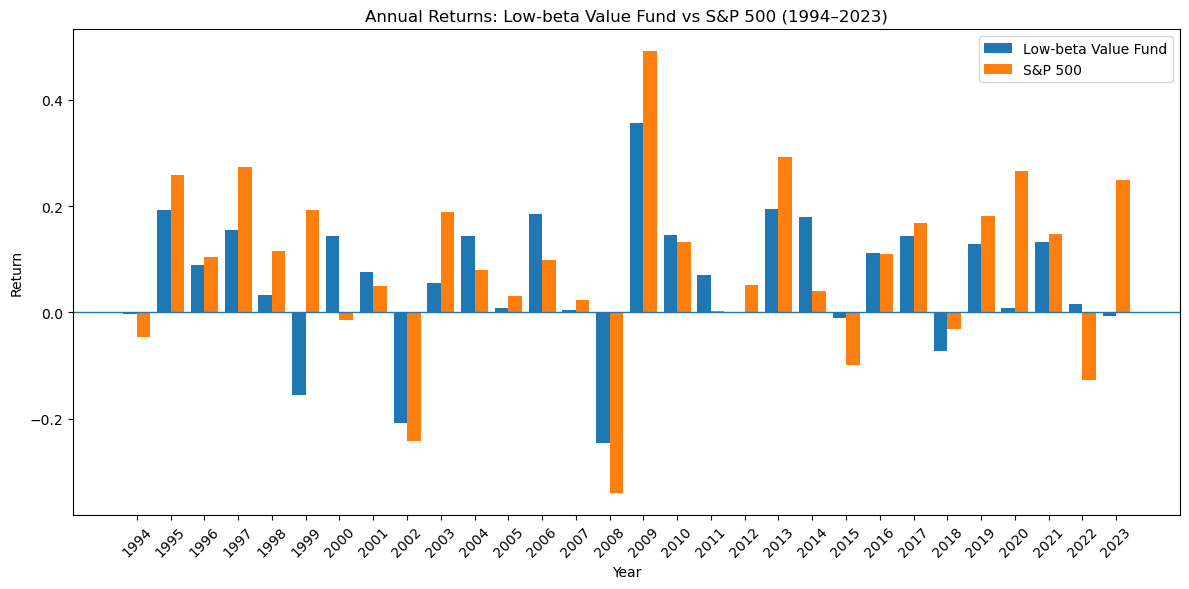

       Fund (%)  SP500 (%)  Fund - SP500 (pp)
date                                         
1994  -0.304593  -4.553864           4.249271
1995  19.193419  25.818506          -6.625087
1996   8.970927  10.467434          -1.496508
1997  15.466052  27.285475         -11.819423
1998   3.330701  11.616964          -8.286263
1999 -15.509772  19.224507         -34.734279
2000  14.394396  -1.523431          15.917827
2001   7.536440   4.901291           2.635149
2002 -20.809342 -24.162267           3.352925
2003   5.494579  18.863984         -13.369405
2004  14.407662   7.911672           6.495990
2005   0.724544   3.057105          -2.332561
2006  18.458389   9.851024           8.607366
2007   0.528560   2.264694          -1.736134
2008 -24.658352 -33.957781           9.299429
2009  35.658868  49.139718         -13.480850
2010  14.610330  13.266064           1.344265
2011   7.039025   0.214881           6.824144
2012  -0.173572   5.131355          -5.304928
2013  19.405619  29.276137        

In [74]:
# === Side-by-side annual returns: Low-beta fund vs S&P 500 ===

# Compute annual returns for both from `combined`
annual_both = (1 + combined[['low_beta', 'sp500']]) \
    .groupby(combined.index.year) \
    .prod() - 1

# Restrict to 1994–2023 just in case
annual_both = annual_both.loc[1994:2023]

# Rename columns for clarity
annual_both = annual_both.rename(columns={
    'low_beta': 'Fund',
    'sp500': 'SP500'
})

# --- Plot side-by-side bars ---
years = annual_both.index.values
fund_ret = annual_both['Fund'].values
sp_ret   = annual_both['SP500'].values

x = np.arange(len(years))
width = 0.4  # width of each bar

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, fund_ret, width, label='Low-beta Value Fund')
plt.bar(x + width/2, sp_ret,  width, label='S&P 500')

plt.axhline(0, linewidth=1)
plt.xticks(x, years, rotation=45)
plt.xlabel("Year")
plt.ylabel("Return")
plt.title("Annual Returns: Low-beta Value Fund vs S&P 500 (1994–2023)")
plt.legend()
plt.tight_layout()
plt.show()

# --- Print comparison table (in %) ---
annual_comp = annual_both.copy()
annual_comp['Fund (%)'] = annual_comp['Fund'] * 100
annual_comp['SP500 (%)'] = annual_comp['SP500'] * 100
annual_comp['Fund - SP500 (pp)'] = (annual_comp['Fund'] - annual_comp['SP500']) * 100

print(annual_comp[['Fund (%)', 'SP500 (%)', 'Fund - SP500 (pp)']])


This cell builds a unified monthly dataset with the baseline value portfolio, low-beta value portfolio, S&P 500, and Fama–French factors, then computes summary performance metrics (returns, volatility, Sharpe, beta, max drawdown) for each in percentage terms. It also plots the growth of $100 over time for all three portfolios, providing a visual comparison of cumulative performance.








Summary metrics (in % where applicable):
                  Low-beta value  Baseline value    S&P 500
Mean monthly (%)        0.717045        0.701571   0.957126
Vol monthly (%)         4.153082        5.505551   4.464438
Sharpe (monthly)        0.125865        0.092169   0.171049
Mean annual (%)         8.952126        8.751425  12.109843
Vol annual (%)         14.386698       19.071789  15.465266
Beta (vs MktRF)         0.424956        1.042888   0.958248
Max drawdown (%)      -26.826938      -49.227104 -37.865574


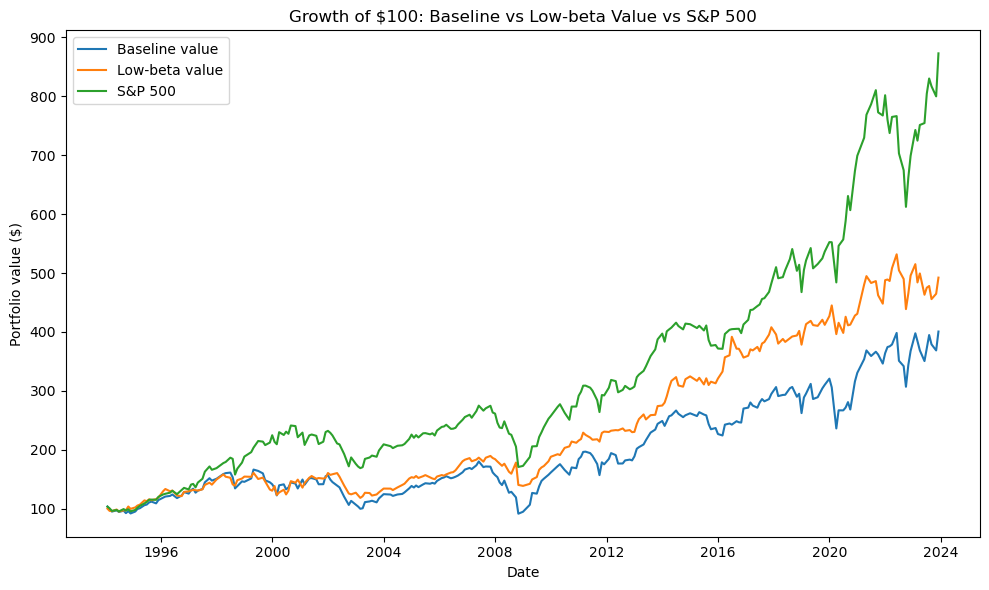

In [75]:
# ========= 1. Build combined monthly DataFrame =========
# Assumes you already have:
# - port_ret with index=date, col 'ret_port'     (baseline value)
# - port_ret_bn with index=date, col 'ret_port_bn' (low-beta value)
# - sp with 'date', 'ret_sp'                    (S&P 500 total return, decimal)
# - ff_monthly with 'date', 'mktrf', 'rf'       (monthly market & RF, decimal)

combined = (
    port_ret.reset_index().rename(columns={'ret_port': 'baseline'})
    .merge(
        port_ret_bn.reset_index().rename(columns={'ret_port_bn': 'low_beta'}),
        on='date',
        how='inner'
    )
    .merge(
        sp[['date', 'ret_sp']].rename(columns={'ret_sp': 'sp500'}),
        on='date',
        how='inner'
    )
    .merge(
        ff_monthly[['date', 'mktrf', 'rf']],
        on='date',
        how='inner'
    )
    .set_index('date')
    .sort_index()
)

# ========= 2. Metric function (returns in PERCENT) =========

def compute_metrics(ret, rf, mktrf):
    """
    ret, rf, mktrf: monthly returns in decimal form (Series aligned on same dates).
    Returns metrics with return/vol/dd in PERCENT, beta & Sharpe unitless.
    """
    df = pd.concat([ret, rf, mktrf], axis=1).dropna()
    r = df.iloc[:, 0]
    rf_s = df.iloc[:, 1]
    mktrf_s = df.iloc[:, 2]

    ex = r - rf_s

    mean_m   = r.mean()
    vol_m    = r.std()
    sharpe_m = ex.mean() / ex.std()

    mean_ann = (1 + mean_m)**12 - 1
    vol_ann  = vol_m * np.sqrt(12)

    # Beta vs market excess
    if mktrf_s.var() != 0:
        beta = np.cov(ex, mktrf_s)[0, 1] / np.var(mktrf_s)
    else:
        beta = np.nan

    # Max drawdown
    cum = (1 + r).cumprod()
    peak = cum.cummax()
    dd = cum / peak - 1
    max_dd = dd.min()

    return {
        'Mean monthly (%)':   mean_m * 100,
        'Vol monthly (%)':    vol_m * 100,
        'Sharpe (monthly)':   sharpe_m,
        'Mean annual (%)':    mean_ann * 100,
        'Vol annual (%)':     vol_ann * 100,
        'Beta (vs MktRF)':    beta,
        'Max drawdown (%)':   max_dd * 100,
    }

metrics = {}
metrics['Low-beta value'] = compute_metrics(
    combined['low_beta'],
    combined['rf'],
    combined['mktrf']
)
metrics['Baseline value'] = compute_metrics(
    combined['baseline'],
    combined['rf'],
    combined['mktrf']
)
metrics['S&P 500'] = compute_metrics(
    combined['sp500'],
    combined['rf'],
    combined['mktrf']
)

metrics_df = pd.DataFrame(metrics)
print("Summary metrics (in % where applicable):")
print(metrics_df)

# ========= 3. "Map" tracking value over time (equity curves) =========

equity = (1 + combined[['baseline', 'low_beta', 'sp500']]).cumprod()
equity_100 = equity * 100  # start at 100 instead of 1

plt.figure(figsize=(10, 6))
plt.plot(equity_100.index, equity_100['baseline'], label='Baseline value')
plt.plot(equity_100.index, equity_100['low_beta'], label='Low-beta value')
plt.plot(equity_100.index, equity_100['sp500'], label='S&P 500')
plt.title("Growth of $100: Baseline vs Low-beta Value vs S&P 500")
plt.xlabel("Date")
plt.ylabel("Portfolio value ($)")
plt.legend()
plt.tight_layout()
plt.show()


This cell recomputes calendar-year returns for the low-beta value fund and the S&P 500 from the combined monthly data, then forms an annual excess return series (Fund − S&P). It summarizes this excess series by reporting its mean, volatility, and Sharpe ratio in annual terms, quantifying how the fund has performed relative to the S&P on a year-by-year basis.


In [76]:
# === 1. Rebuild annual fund & S&P returns from `combined` ===
# Assumes `combined` is already built and has columns: 'low_beta', 'sp500'

# Annual total returns by calendar year
annual = (1 + combined[['low_beta', 'sp500']]) \
    .groupby(combined.index.year) \
    .prod() - 1

# Just to be explicit
annual_fund = annual['low_beta']
annual_sp   = annual['sp500']

# Restrict to overlapping years, just in case
common_years = annual_fund.index.intersection(annual_sp.index)
annual_fund = annual_fund.loc[common_years]
annual_sp   = annual_sp.loc[common_years]

# === 2. Annual excess stats: fund vs S&P ===
annual_excess = annual_fund - annual_sp

mean_excess = annual_excess.mean()
std_excess  = annual_excess.std()

if std_excess == 0 or np.isnan(std_excess):
    sharpe_excess = np.nan
else:
    sharpe_excess = mean_excess / std_excess

summary_excess_annual = pd.Series({
    'Mean annual excess (%)': mean_excess * 100,
    'Vol annual excess (%)':  std_excess * 100,
    'Sharpe (annual excess)': sharpe_excess
})

print("Annual excess return statistics (Fund - S&P):")
print(summary_excess_annual)


Annual excess return statistics (Fund - S&P):
Mean annual excess (%)    -2.586204
Vol annual excess (%)     11.952039
Sharpe (annual excess)    -0.216382
dtype: float64


This cell inspects the fund’s most recent holdings by taking the last quarter’s beta-targeted weights, merging on firm characteristics (size, value, beta) and tickers, and then ranking stocks by portfolio weight. It reports the top 10 positions with their weights and fundamentals, along with the total percentage of NAV concentrated in these top names at the end of the sample.


In [77]:
# === Top 10 holdings at end of sample (low-beta value fund) ===

# Last quarter-end
last_q = port_holdings_bn['qdate'].max()

hold_last = port_holdings_bn[port_holdings_bn['qdate'] == last_q].copy()

# Merge in some characteristics (BM, beta, MC)
sig_last = sig[sig['date'] == last_q][['permno', 'MC', 'BM', 'beta']]
hold_last = hold_last.merge(sig_last, on='permno', how='left')

# Grab tickers from msf for the same year/month as last_q
msf_last_month = msf[
    (msf['date'].dt.year == last_q.year) &
    (msf['date'].dt.month == last_q.month)
][['permno', 'ticker']].drop_duplicates('permno')

# Merge tickers onto holdings
hold_last = hold_last.merge(msf_last_month, on='permno', how='left')

# Sort by portfolio weight and rebuild top 10
hold_last = hold_last.sort_values('w_bn', ascending=False)
top10 = hold_last.head(10).copy()
top10['weight_pct'] = top10['w_bn'] * 100

top10_conc = top10['w_bn'].sum() * 100

print("Top 10 holdings at", last_q.date())
print(top10[['permno', 'ticker', 'w_bn', 'weight_pct', 'MC', 'BM', 'beta']])
print(f"\nTop-10 concentration: {top10_conc:.2f}% of NAV")




Top 10 holdings at 2023-12-29
    permno ticker      w_bn  weight_pct          MC        BM      beta
35   65875     VZ  0.164313   16.431348  158.494645  0.878566  0.372049
5    17005    CVS  0.105344   10.534393  101.613387  0.760864  0.489535
34   64186     CI  0.090842    9.084205   87.625059  0.605295  0.517421
6    18411     SO  0.079282    7.928181   76.474204  0.567329  0.480279
24   27959    DUK  0.077536    7.753566   74.789892  0.767885  0.439891
21   24109    AEP  0.044280    4.427973   42.711649  0.773552  0.465051
39   89269    CNC  0.041098    4.109848   39.643056  0.660040  0.384810
13   21776    EXC  0.037048    3.704818   35.736188  1.021244  0.503956
19   23931    XEL  0.035417    3.541716   34.162929  0.629198  0.359369
0    11404     ED  0.032558    3.255763   31.404663  0.905502  0.306694

Top-10 concentration: 70.77% of NAV


This cell merges the low-beta value fund’s returns with Fama–French three-factor data (market, size, value), computes the fund’s excess return, and runs an FF3 regression of excess returns on MktRF, SMB, and HML. Using HAC standard errors, it estimates the fund’s factor loadings and alpha to quantify its exposures to market, size, and value premia.








In [78]:
df_ff = df_perf.merge(
    ff_monthly[['date','mktrf','smb','hml']],
    left_index=True,
    right_on='date',
    how='inner'
).set_index('date')

df_ff['excess'] = df_ff['ret_fund'] - df_ff['rf']

Y = df_ff['excess']
X = sm.add_constant(df_ff[['mktrf','smb','hml']])

ff3_res = sm.OLS(Y, X).fit(cov_type='HAC', cov_kwds={'maxlags':6})
print(ff3_res.summary())

                            OLS Regression Results                            
Dep. Variable:                 excess   R-squared:                       0.368
Model:                            OLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                     42.64
Date:                Tue, 09 Dec 2025   Prob (F-statistic):           2.63e-22
Time:                        18:03:24   Log-Likelihood:                 508.33
No. Observations:                 255   AIC:                            -1009.
Df Residuals:                     251   BIC:                            -994.5
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.002      0.476      0.6

This cell computes calendar-year returns for the low-beta value fund and the S&P 500, then calculates trailing compounded average annual returns (CAGRs) over 1-, 3-, 5-, 10-, and 30-year windows. It summarizes these CAGRs in a table, allowing a direct comparison of long-horizon performance between the fund and the S&P across multiple investment horizons.








In [79]:
# ========= 1. Build annual return series for fund and S&P =========

# Annual total returns: (1+r_month)^12ish → (1+r_year)
annual_fund = (1 + combined['low_beta']).groupby(combined.index.year).prod() - 1
annual_sp   = (1 + combined['sp500']).groupby(combined.index.year).prod() - 1

# Restrict to overlapping years just in case
common_years = annual_fund.index.intersection(annual_sp.index)
annual_fund = annual_fund.loc[common_years]
annual_sp   = annual_sp.loc[common_years]

# ========= 2. Helper: CAGR over the last N years =========

def cagr_last_n_years(annual_series, n):
    """
    Computes the compounded average annual return over the last n years
    of an annual return series.
    """
    if len(annual_series) < n:
        return np.nan  # not enough history

    end_year = annual_series.index.max()
    start_year = end_year - n + 1
    sub = annual_series.loc[start_year:end_year]

    total_return = (1 + sub).prod() - 1
    # Compounded average annual rate over that window
    cagr = (1 + total_return)**(1 / len(sub)) - 1
    return cagr

# ========= 3. Compute CAGRs for 1, 3, 5, 10, 30 years =========

horizons = [1, 3, 5, 10, 30]
rows = {}
for n in horizons:
    rows[f"Last {n} years"] = {
        "Fund CAGR (%)": cagr_last_n_years(annual_fund, n) * 100,
        "S&P CAGR (%)":  cagr_last_n_years(annual_sp, n) * 100,
    }

benchmarks_df = pd.DataFrame(rows).T
print("Compounded average annual return over trailing windows (in %):")
print(benchmarks_df)

Compounded average annual return over trailing windows (in %):
               Fund CAGR (%)  S&P CAGR (%)
Last 1 years       -0.702040     24.889434
Last 3 years        4.539684      7.684338
Last 5 years        5.401084     13.295605
Last 10 years       5.989426      8.191985
Last 30 years       5.456360      7.489537
